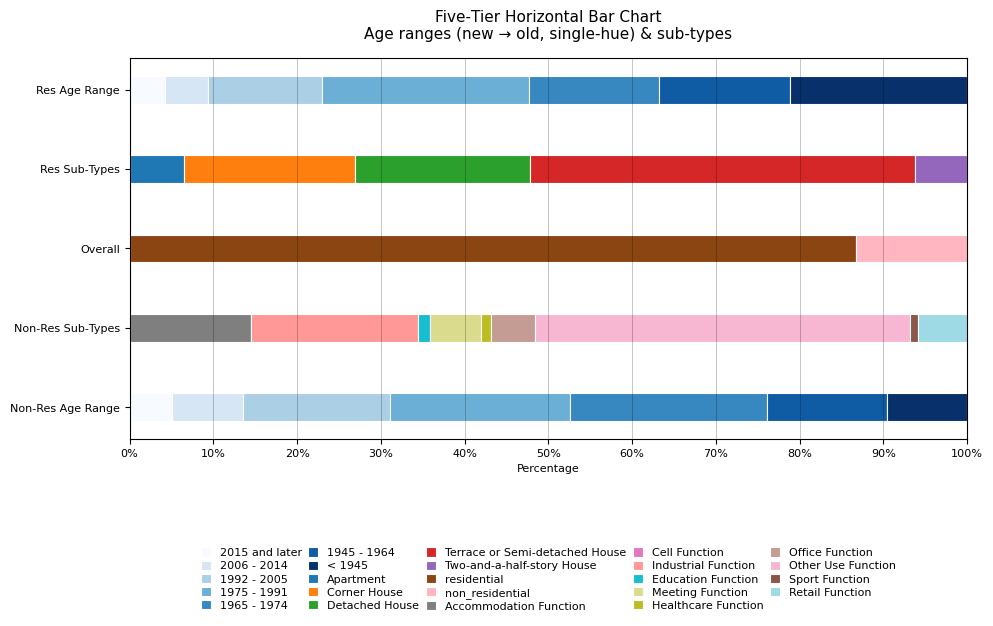

In [10]:
"""
Five‑tier horizontal stacked bar chart
• narrow bars (bar_height = 0.35)  
• age‑range tiers coloured with a single‑hue gradient (new → old, light → dark)  
Author : <you> – 2025‑04‑18
"""

# ---------------------------------------------------------------------------
# 0) Imports & settings
# ---------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import matplotlib.colors as mcol
from matplotlib.patches import Patch

CSV_PATH  = r"D:/dmg.csv"     # ◀─ change to your CSV
AGE_COL   = "age_range"       # ◀─ change if your column is named differently

BAR_HEIGHT = 0.35
FONT_S     = 8
FONT_L     = 11

# ---------------------------------------------------------------------------
# 1) Read CSV
# ---------------------------------------------------------------------------
df = pd.read_csv(CSV_PATH)

# Expected columns (minimum):
#   building_function       "residential" | "non_residential"
#   residential_type        (only for residential rows)
#   non_residential_type    (only for non‑residential rows)
#   age_range               categorical bucket (same for both groups)
#   count_buildings         numeric
#
# If your CSV is at a different aggregation level (one line per building) just
# add a dummy column `count_buildings = 1` before aggregating.

# ---------------------------------------------------------------------------
# 2) Helper – percentage breakdown for “stacked bar” segments
# ---------------------------------------------------------------------------
def pct_breakdown(frame, group_col, *, where=None, sort_key=None):
    """
    Returns a list of (percentage, label) tuples suitable for stacked plotting.
    - frame: DataFrame to aggregate
    - group_col: column name to group by
    - where: optional boolean mask to pre‑filter rows
    - sort_key: optional function(label) -> numeric key for custom ordering
    """
    if where is not None:
        frame = frame[where].copy()

    agg = (frame.groupby(group_col, as_index=False)["count_buildings"]
                 .sum())

    total = agg["count_buildings"].sum()
    agg["pct"] = 100 * agg["count_buildings"] / total

    if sort_key:
        agg["sort_key"] = agg[group_col].map(sort_key)
        agg.sort_values("sort_key", inplace=True)
    else:
        agg.sort_values(group_col, inplace=True)

    return list(zip(agg["pct"], agg[group_col]))

# ---------------------------------------------------------------------------
# 3) Segment lists for the five tiers
# ---------------------------------------------------------------------------
# 3a) Overall residential / non‑residential
overall_segments = pct_breakdown(
    df, "building_function",
    sort_key=lambda x: {"residential": 0, "non_residential": 1}.get(x, 99))

# 3b) Residential sub‑types (alphabetical)
res_sub_segments = pct_breakdown(
    df, "residential_type",
    where=df["building_function"] == "residential")

# 3c) Non‑residential sub‑types (custom order)
NONRES_ORDER = [
    "Accommodation Function", "Cell Function",
    "Industrial Function", "Education Function",     # after Industrial
    "Meeting Function", "Healthcare Function",       # after Meeting
    "Office Function", "Other Use Function",
    "Sport Function",                                # after Other Use
    "Retail Function"
]
nonres_sub_segments = pct_breakdown(
    df, "non_residential_type",
    where=df["building_function"] == "non_residential",
    sort_key=lambda x: NONRES_ORDER.index(x) if x in NONRES_ORDER else 999)

# 3d / 3e) Age‑range tiers
AGE_ORDER = [
    "2015 and later",
    "2006 - 2014",
    "1992 - 2005",
    "1975 - 1991",
    "1965 - 1974",
    "1945 - 1964",
    "< 1945"
]

res_age_segments = pct_breakdown(
    df, AGE_COL,
    where=df["building_function"] == "residential",
    sort_key=lambda x: AGE_ORDER.index(x) if x in AGE_ORDER else 999)

non_age_segments = pct_breakdown(
    df, AGE_COL,
    where=df["building_function"] == "non_residential",
    sort_key=lambda x: AGE_ORDER.index(x) if x in AGE_ORDER else 999)

# ---------------------------------------------------------------------------
# 4) Colour map
# ---------------------------------------------------------------------------
color_map = {
    # high‑level
    "residential":       "#8B4513",
    "non_residential":   "#FFB6C1",

    # Residential sub‑types
    "Apartment":                     "#1f77b4",
    "Corner House":                  "#ff7f0e",
    "Detached House":                "#2ca02c",
    "Terrace or Semi-detached House":"#d62728",
    "Two-and-a-half-story House":    "#9467bd",

    # Non‑residential sub‑types
    "Accommodation Function": "#7f7f7f",
    "Cell Function":          "#e377c2",
    "Industrial Function":    "#ff9896",
    "Education Function":     "#17becf",
    "Meeting Function":       "#dbdb8d",
    "Healthcare Function":    "#bcbd22",
    "Office Function":        "#c49c94",
    "Other Use Function":     "#f7b6d2",
    "Sport Function":         "#8c564b",
    "Retail Function":        "#9edae5",
}

# 4b) Age‑range palette – single hue, light → dark
blues = cm.get_cmap("Blues", len(AGE_ORDER))
age_palette = {lab: mcol.to_hex(blues(i)) for i, lab in enumerate(AGE_ORDER)}
color_map.update(age_palette)          # overwrite the default greys

fallback_color = "#cccccc"             # for any unexpected labels

# ---------------------------------------------------------------------------
# 5) Plot helper – draw one horizontal stacked bar
# ---------------------------------------------------------------------------
def draw_stacked_barh(ax, segments, y_pos,
                      *, bar_height=BAR_HEIGHT, edge_col="white"):
    left = 0.0
    for pct, label in segments:
        ax.barh(y=y_pos, width=pct, left=left,
                height=bar_height,
                color=color_map.get(label, fallback_color),
                edgecolor=edge_col, linewidth=.8)
        left += pct

# ---------------------------------------------------------------------------
# 6) Build the figure
# ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6.2))

# vertical positions (top → bottom)
y_res_age, y_res_sub, y_overall, y_non_sub, y_non_age = 4, 3, 2, 1, 0

draw_stacked_barh(ax, res_age_segments,     y_res_age)
draw_stacked_barh(ax, res_sub_segments,     y_res_sub)
draw_stacked_barh(ax, overall_segments,     y_overall)
draw_stacked_barh(ax, nonres_sub_segments,  y_non_sub)
draw_stacked_barh(ax, non_age_segments,     y_non_age)

# Y‑labels
ax.set_yticks([y_non_age, y_non_sub, y_overall, y_res_sub, y_res_age])
ax.set_yticklabels(["Non‑Res Age Range",
                    "Non‑Res Sub‑Types",
                    "Overall",
                    "Res Sub‑Types",
                    "Res Age Range"],
                   fontsize=FONT_S)

# X‑axis (percent)
ax.set_xlim(0, 100)
ax.set_xlabel("Percentage", fontsize=FONT_S)
ax.set_xticks(range(0, 101, 10))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.tick_params(axis='x', labelsize=FONT_S)
ax.grid(axis='x', color='black', linewidth=.4, alpha=.4)

# Title
ax.set_title("Five‑Tier Horizontal Bar Chart\n"
             "Age ranges (new → old, single‑hue) & sub‑types",
             fontsize=FONT_L, pad=14)

# ---------------------------------------------------------------------------
# 7) Legend (collect labels in appearance order)
# ---------------------------------------------------------------------------
labels_in_order = (
      [l for _, l in res_age_segments]
    + [l for _, l in res_sub_segments]
    + [l for _, l in overall_segments]
    + [l for _, l in nonres_sub_segments]
    + [l for _, l in non_age_segments])
labels_unique = list(dict.fromkeys(labels_in_order))

handles = [Patch(facecolor=color_map.get(l, fallback_color),
                 edgecolor="white", linewidth=.8)
           for l in labels_unique]

ax.legend(handles, labels_unique,
          loc="upper center",
          bbox_to_anchor=(0.5, -0.26),  # push legend below the axes
          ncol=5,
          fontsize=FONT_S,
          frameon=False,
          handlelength=.9, handleheight=.9,
          columnspacing=.6,
          labelspacing=.25)

plt.subplots_adjust(bottom=0.35)       # room for legend
plt.tight_layout()
plt.show()


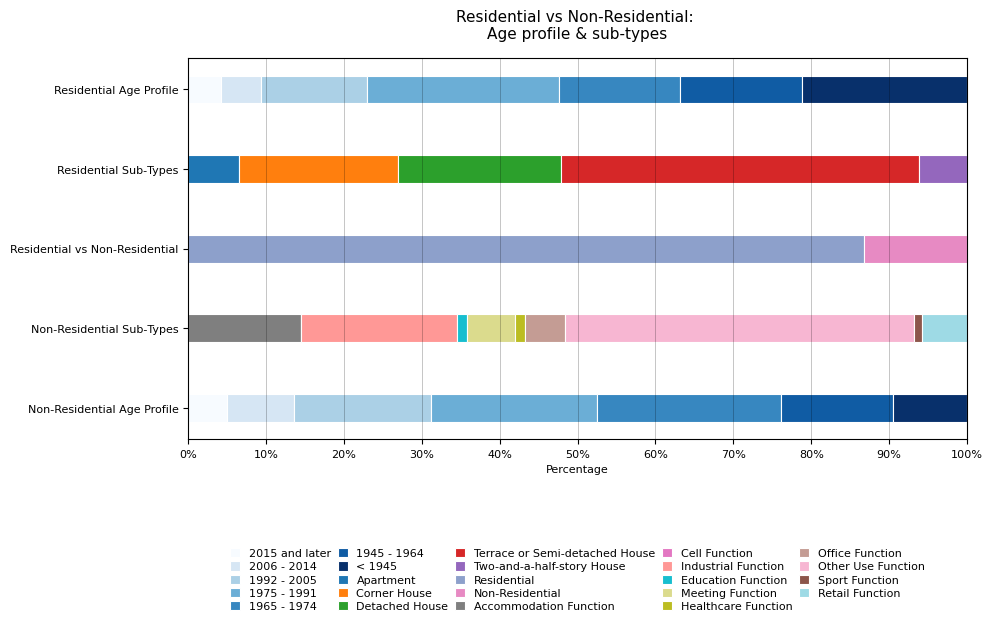

In [14]:
"""
Five‑tier horizontal stacked bar chart
• narrow bars
• single‑hue gradient for age ranges (new → old)
• muted greys for the overall Residential / Non‑Residential split
Author : <you> – 2025‑04‑18
"""

# ---------------------------------------------------------------------------
# 0) Imports & settings
# ---------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import matplotlib.colors as mcol
from matplotlib.patches import Patch

CSV_PATH  = r"D:/dmg.csv"     # ◀─ change to your CSV
AGE_COL   = "age_range"       # ◀─ change if needed

BAR_HEIGHT = 0.35
FONT_S     = 8
FONT_L     = 11

# ---------------------------------------------------------------------------
# 1) Read CSV
# ---------------------------------------------------------------------------
df = pd.read_csv(CSV_PATH)

# ---------------------------------------------------------------------------
# 2) Helper – percentage breakdown for stacked‑bar segments
# ---------------------------------------------------------------------------
def pct_breakdown(frame, group_col, *, where=None, sort_key=None, label_map=None):
    """
    Returns a list of (percentage, label) tuples for stacked plotting.
        where      : optional boolean mask to pre‑filter rows
        sort_key   : optional func(label) -> numeric  (for custom ordering)
        label_map  : optional dict original_label -> display_label
    """
    if where is not None:
        frame = frame[where].copy()

    lab_col = group_col
    if label_map:
        frame = frame.copy()
        frame[group_col] = frame[group_col].map(label_map).fillna(frame[group_col])
        lab_col = group_col     # now already mapped

    agg = (frame.groupby(lab_col, as_index=False)["count_buildings"]
                 .sum())

    total = agg["count_buildings"].sum()
    agg["pct"] = 100 * agg["count_buildings"] / total

    if sort_key:
        agg["sort_key"] = agg[lab_col].map(sort_key)
        agg.sort_values("sort_key", inplace=True)
    else:
        agg.sort_values(lab_col, inplace=True)

    return list(zip(agg["pct"], agg[lab_col]))

# ---------------------------------------------------------------------------
# 3) Segment lists for the five tiers
# ---------------------------------------------------------------------------
# 3a) Overall Residential / Non‑Residential (muted greys)
DISPLAY_MAP_FN = {"residential": "Residential",
                  "non_residential": "Non‑Residential"}
overall_segments = pct_breakdown(
    df, "building_function",
    label_map=DISPLAY_MAP_FN,
    sort_key=lambda x: {"Residential": 0, "Non‑Residential": 1}.get(x, 99))

# 3b) Residential sub‑types
res_sub_segments = pct_breakdown(
    df, "residential_type",
    where=df["building_function"] == "residential")

# 3c) Non‑residential sub‑types (custom order)
NONRES_ORDER = [
    "Accommodation Function", "Cell Function",
    "Industrial Function", "Education Function",
    "Meeting Function", "Healthcare Function",
    "Office Function", "Other Use Function",
    "Sport Function", "Retail Function"
]
nonres_sub_segments = pct_breakdown(
    df, "non_residential_type",
    where=df["building_function"] == "non_residential",
    sort_key=lambda x: NONRES_ORDER.index(x) if x in NONRES_ORDER else 999)

# 3d / 3e) Age‑range tiers
AGE_ORDER = [
    "2015 and later",
    "2006 - 2014",
    "1992 - 2005",
    "1975 - 1991",
    "1965 - 1974",
    "1945 - 1964",
    "< 1945"
]
res_age_segments = pct_breakdown(
    df, AGE_COL,
    where=df["building_function"] == "residential",
    sort_key=lambda x: AGE_ORDER.index(x) if x in AGE_ORDER else 999)

non_age_segments = pct_breakdown(
    df, AGE_COL,
    where=df["building_function"] == "non_residential",
    sort_key=lambda x: AGE_ORDER.index(x) if x in AGE_ORDER else 999)

# ---------------------------------------------------------------------------
# 4) Colour palette
# ---------------------------------------------------------------------------
color_map = {
    # muted greys for the overall split
    "Residential":      "#8da0cb",
    "Non‑Residential":  "#e78ac3",

    # Residential sub‑types
    "Apartment":                     "#1f77b4",
    "Corner House":                  "#ff7f0e",
    "Detached House":                "#2ca02c",
    "Terrace or Semi-detached House":"#d62728",
    "Two-and-a-half-story House":    "#9467bd",

    # Non‑residential sub‑types
    "Accommodation Function": "#7f7f7f",
    "Cell Function":          "#e377c2",
    "Industrial Function":    "#ff9896",
    "Education Function":     "#17becf",
    "Meeting Function":       "#dbdb8d",
    "Healthcare Function":    "#bcbd22",
    "Office Function":        "#c49c94",
    "Other Use Function":     "#f7b6d2",
    "Sport Function":         "#8c564b",
    "Retail Function":        "#9edae5",
}

# single‑hue gradient for age ranges (Blues, light → dark)
blues = cm.get_cmap("Blues", len(AGE_ORDER))
color_map.update({lab: mcol.to_hex(blues(i)) for i, lab in enumerate(AGE_ORDER)})

fallback_color = "#cccccc"

# ---------------------------------------------------------------------------
# 5) Plot helper – draw one stacked bar
# ---------------------------------------------------------------------------
def draw_stacked_barh(ax, segments, y_pos,
                      *, bar_height=BAR_HEIGHT, edge_col="white"):
    left = 0.0
    for pct, label in segments:
        ax.barh(y=y_pos, width=pct, left=left,
                height=bar_height,
                color=color_map.get(label, fallback_color),
                edgecolor=edge_col, linewidth=.8)
        left += pct

# ---------------------------------------------------------------------------
# 6) Figure
# ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6.2))

# positions (top → bottom)
y_res_age, y_res_sub, y_overall, y_non_sub, y_non_age = 4, 3, 2, 1, 0

draw_stacked_barh(ax, res_age_segments,     y_res_age)
draw_stacked_barh(ax, res_sub_segments,     y_res_sub)
draw_stacked_barh(ax, overall_segments,     y_overall)
draw_stacked_barh(ax, nonres_sub_segments,  y_non_sub)
draw_stacked_barh(ax, non_age_segments,     y_non_age)

# Y‑axis labels – nicer wording
ax.set_yticks([y_non_age, y_non_sub, y_overall, y_res_sub, y_res_age])
ax.set_yticklabels(["Non‑Residential Age Profile",
                    "Non‑Residential Sub‑Types",
                    "Residential vs Non‑Residential",
                    "Residential Sub‑Types",
                    "Residential Age Profile"],
                   fontsize=FONT_S)

# X‑axis
ax.set_xlim(0, 100)
ax.set_xlabel("Percentage", fontsize=FONT_S)
ax.set_xticks(range(0, 101, 10))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.tick_params(axis='x', labelsize=FONT_S)
ax.grid(axis='x', color='black', linewidth=.4, alpha=.4)

# Title
ax.set_title("Residential vs Non‑Residential: \n"
             "Age profile & sub‑types",
             fontsize=FONT_L, pad=14)

# ---------------------------------------------------------------------------
# 7) Legend – keep order of appearance
# ---------------------------------------------------------------------------
labels_in_order = (
      [l for _, l in res_age_segments]
    + [l for _, l in res_sub_segments]
    + [l for _, l in overall_segments]
    + [l for _, l in nonres_sub_segments]
    + [l for _, l in non_age_segments])
labels_unique = list(dict.fromkeys(labels_in_order))

handles = [Patch(facecolor=color_map.get(l, fallback_color),
                 edgecolor="white", linewidth=.8)
           for l in labels_unique]

ax.legend(handles, labels_unique,
          loc="upper center",
          bbox_to_anchor=(0.5, -0.26),
          ncol=5,
          fontsize=FONT_S,
          frameon=False,
          handlelength=.9, handleheight=.9,
          columnspacing=.6,
          labelspacing=.25)

plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd

file_path = r"G:\data\Data\TNO-2023-P10648_vbobestand.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

print("Headers:", df.columns.tolist())
df.head()


Headers: ['vboid', 'vbo_ligt_binnen_x_panden', 'vboid_x', 'vboid_binnen_ander_pand', 'vbo_opp_m2', 'vbo_opp_cor_m2', 'vbo_opp_m2_x', 'pandid', 'bouwjaar', 'aantal_vbo_in_dit_pand', 'vboid_x_agg', 'grond_opp_m2', 'rond', 'pc6', 'pc4', 'wijkcode', 'wijknaam', 'gemeentenaam', 'gemeente_id', 'provincienaam', 'prov_id', 'resnaam', 'res_id', 'odnaam', 'od_afkorting', 'od_id', 'verblijfsobjectgebruiksdoel', 'f1woon', 'f2kantoor', 'f3bijeenkomst', 'f4onderwijs', 'f5winkel', 'f6sport', 'f7logies', 'f8gezondheidszorg', 'f9industrie', 'f10cel', 'f11overig', 'f12bedrpand_zvbo_industrie', 'f13bedrpand_zvbo_groen', 'n_functies', 'promotie', 'f1woon_m2', 'f2kantoor_m2', 'f3bijeenkomst_m2', 'f4onderwijs_m2', 'f5winkel_m2', 'f6sport_m2', 'f7logies_m2', 'f8gezondheidszorg_m2', 'f9industrie_m2', 'f10cel_m2', 'f11overig_m2', 'f12bedrpand_zvbo_industrie_m2', 'f13bedrpand_zvbo_groen_m2', 'm2_functies', 'pand_max_pr_string_agg', 'binnen_bedrijventerrein', 'kas_warenhuis', 'identificatie_kas', 'travo', 'hoofd

,vboid,vbo_ligt_binnen_x_panden,vboid_x,vboid_binnen_ander_pand,vbo_opp_m2,vbo_opp_cor_m2,vbo_opp_m2_x,pandid,bouwjaar,aantal_vbo_in_dit_pand,...,label,isso_nen,ei_origineel,label_origineel,gf_nta_epa,pand_label_keus,warmtenet,warmtenet_pbl1,warmtenet_pbl,in_ubouwpand
0,1.930100e+14,1.0,v0193010000030663_1,0,548.0,548.0,548.0,193100000029998,1977,1,...,NaN,NaN,NaN,NaN,NaN,F,NaN,0,NaN,1
1,1.600100e+14,1.0,v0160010000051304_1,0,42.0,42.0,42.0,160100001392420,1989,1,...,NaN,NaN,NaN,NaN,NaN,E,NaN,0,NaN,1
2,3.920100e+14,1.0,v0392010000003208_1,0,2982.0,2982.0,2982.0,392100000061537,1993,2,...,NaN,NaN,NaN,NaN,NaN,D,NaN,0,NaN,1
3,6.320100e+14,1.0,v0632010000007072_1,0,1198.0,1198.0,1198.0,632100000015217,1950,1,...,1.0,NTA,NaN,A,Kantoorfunctie,A,nee,0,NaN,1
4,3.630100e+14,1.0,v0363010000810818_1,0,1.0,1.0,1.0,363100012075402,1971,1,...,NaN,NaN,NaN,NaN,NaN,G,NaN,0,NaN,1


In [1]:
import pandas as pd
import numpy as np
import re # Import regular expressions module

# --- Configuration ---
# !! Please replace these paths with the actual paths to your CSV files !!
building_data_path = r"D:\Documents\E_Plus_2030_py\output\3066HG-\extracted_idf_buildings.csv"
energy_data_path = r"D:\Documents\E_Plus_2030_py\output\3066HG-\results\merged_daily_mean.csv"

# --- 1. Load Data ---
try:
    print(f"Loading building data from: {building_data_path}")
    # Load building data, assuming BuildingID in energy data corresponds to the index
    df_buildings = pd.read_csv(building_data_path)
    print(f"Building data loaded successfully. Shape: {df_buildings.shape}")
    print("\nBuilding Data Columns:")
    print(df_buildings.columns.tolist())

    print(f"\nLoading energy data from: {energy_data_path}")
    df_energy_raw = pd.read_csv(energy_data_path)
    print(f"Energy data loaded successfully. Shape: {df_energy_raw.shape}")
    print("\nEnergy Data Columns:")
    print(df_energy_raw.columns.tolist())

except FileNotFoundError:
    print("Error: One or both CSV files not found. Please check the file paths.")
    exit()
except Exception as e:
    print(f"An error occurred while loading data: {e}")
    exit()

# --- 2. Summarize Building Data ---
print("\n--- Building Data Summary ---")

# Select relevant columns for summary
building_summary_cols_numeric = [
    'gem_hoogte', 'gem_bouwlagen', 'b3_opp_dak_plat', 'b3_opp_dak_schuin',
    'area', 'perimeter', 'height', 'bouwjaar', 'average_wwr'
]
building_summary_cols_categorical = [
    'meestvoorkomendelabel', 'b3_dak_type', 'age_range', 'building_function',
    'residential_type', 'non_residential_type', 'north_side', 'east_side',
    'south_side', 'west_side', 'building_orientation_cardinal'
]

# Numeric Summary
print("\nNumeric Columns Summary:")
print(df_buildings[building_summary_cols_numeric].describe())

# Categorical Summary
print("\nCategorical Columns Summary (Value Counts):")
for col in building_summary_cols_categorical:
    if col in df_buildings.columns:
        print(f"\n'{col}':")
        print(df_buildings[col].value_counts(dropna=False)) # include NaN counts
    else:
        print(f"\nWarning: Column '{col}' not found in building data.")

# --- 3. Aggregate Building Data ---
print("\n--- Building Data Aggregation ---")

# Example: Aggregate by 'building_function' and 'age_range'
aggregation_groups = ['building_function', 'age_range']
aggregation_metrics = {
    'area': ['mean', 'median', 'count'],
    'height': ['mean', 'median'],
    'average_wwr': ['mean']
}

# Check if aggregation columns exist
valid_aggregation_groups = [g for g in aggregation_groups if g in df_buildings.columns]

if valid_aggregation_groups:
    print(f"\nAggregating numeric metrics by {valid_aggregation_groups}:")
    try:
        df_buildings_agg = df_buildings.groupby(valid_aggregation_groups).agg(aggregation_metrics)
        # Flatten multi-index columns for better readability
        df_buildings_agg.columns = ['_'.join(col).strip() for col in df_buildings_agg.columns.values]
        print(df_buildings_agg)
    except Exception as e:
        print(f"Error during building data aggregation: {e}")
else:
    print("Skipping building data aggregation as grouping columns are missing.")


# --- 4. Process Energy Data ---
print("\n--- Processing Energy Data ---")

# Identify day columns (e.g., Day_0, Day_1, ...)
day_cols = [col for col in df_energy_raw.columns if col.startswith('Day_')]
if not day_cols:
    print("Error: No 'Day_...' columns found in the energy data.")
    exit()

# Melt the DataFrame from wide to long format
print("Melting energy data from wide to long format...")
id_vars = ['BuildingID', 'VariableName']
df_energy_long = pd.melt(df_energy_raw,
                         id_vars=id_vars,
                         value_vars=day_cols,
                         var_name='Day',
                         value_name='Value_J') # Keep original Joules value

# Extract day number from 'Day' column
df_energy_long['Day_Num'] = df_energy_long['Day'].str.extract('(\d+)').astype(int)

# Convert Joules to kWh (1 kWh = 3.6e6 J)
joules_to_kwh = 3.6e6
df_energy_long['Value_kWh'] = df_energy_long['Value_J'] / joules_to_kwh

# Standardize VariableName (handle DHW variations)
def standardize_variable_name(var_name):
    var_name = var_name.strip() # Remove leading/trailing whitespace
    if re.match(r'MYDHW_.*_WATERHEATER:Water Heater Heating Energy \[J\]\(Daily\)', var_name):
        return 'DHW:EnergyTransfer [kWh](Daily)'
    elif var_name == 'Cooling:EnergyTransfer [J](Daily)':
        return 'Cooling:EnergyTransfer [kWh](Daily)'
    elif var_name == 'Electricity:Facility [J](Daily)':
        return 'Electricity:Facility [kWh](Daily)'
    elif var_name == 'Heating:EnergyTransfer [J](Daily)':
        return 'Heating:EnergyTransfer [kWh](Daily)'
    else:
        # Keep other variables but maybe flag them or use a different unit label
        return var_name.replace('[J]','[kWh]') # Basic replacement for others

df_energy_long['Variable_kWh'] = df_energy_long['VariableName'].apply(standardize_variable_name)

print("Energy data processed.")
print(f"Processed energy data shape: {df_energy_long.shape}")
print("\nSample of processed energy data (long format):")
print(df_energy_long.head())

# --- 5. Summarize Annual Energy Demand ---
print("\n--- Annual Energy Demand Summary (per Building) ---")

# Calculate total annual energy per building per variable type (in kWh)
# We only sum the relevant energy transfer/facility types
energy_vars_to_sum = [
    'Heating:EnergyTransfer [kWh](Daily)',
    'Cooling:EnergyTransfer [kWh](Daily)',
    'Electricity:Facility [kWh](Daily)',
    'DHW:EnergyTransfer [kWh](Daily)'
]

df_annual_energy = df_energy_long[df_energy_long['Variable_kWh'].isin(energy_vars_to_sum)]
df_annual_energy = df_annual_energy.groupby(['BuildingID', 'Variable_kWh'])['Value_kWh'].sum().unstack()

# Rename columns for clarity
df_annual_energy.columns = [col.split(':')[0] + '_kWh_Total' for col in df_annual_energy.columns]

print("\nTotal Annual Energy Consumption per Building (kWh):")
print(df_annual_energy.head())

print("\nSummary Statistics for Annual Energy Consumption (kWh):")
print(df_annual_energy.describe())

# --- 6. Merge Building and Energy Data ---
print("\n--- Merging Building and Energy Data ---")

# Assuming the 'BuildingID' in energy data corresponds to the index of df_buildings
# If 'BuildingID' corresponds to 'ogc_fid' or 'pand_id', change left_index=True to left_on='your_column_name'
try:
    df_merged = pd.merge(
        df_buildings,
        df_annual_energy,
        left_index=True, # Merge on the index of df_buildings
        right_index=True, # Merge on the BuildingID (index) of df_annual_energy
        how='left' # Keep all buildings, even if they have no energy data
    )
    print("Building and energy data merged successfully.")
    print(f"Merged data shape: {df_merged.shape}")
    print("\nSample of merged data:")
    # Display relevant columns from both dataframes
    merged_cols_display = valid_aggregation_groups + list(df_annual_energy.columns)
    print(df_merged[merged_cols_display].head())

except Exception as e:
    print(f"Error merging data: {e}")
    df_merged = None # Set merged df to None if merge fails


# --- 7. Energy Demand Summary based on Aggregation ---
print("\n--- Aggregated Energy Demand Summary ---")

if df_merged is not None and valid_aggregation_groups:
    print(f"\nAggregating Annual Energy Demand (kWh) by {valid_aggregation_groups}:")

    # Define metrics for energy aggregation (e.g., mean, median, sum)
    energy_aggregation_metrics = {col: ['mean', 'median', 'sum'] for col in df_annual_energy.columns}

    try:
        df_energy_agg = df_merged.groupby(valid_aggregation_groups).agg(energy_aggregation_metrics)
        # Flatten multi-index columns
        df_energy_agg.columns = ['_'.join(col).strip() for col in df_energy_agg.columns.values]
        print(df_energy_agg)

        # Example: Average Heating demand per building function
        if 'Heating_kWh_Total_mean' in df_energy_agg.columns and 'building_function' in valid_aggregation_groups:
             print("\nAverage Annual Heating Demand (kWh) per Building Function:")
             # Select only the relevant columns and group by building function if it wasn't the only group
             if 'age_range' in valid_aggregation_groups: # If grouped by multiple cols
                 print(df_energy_agg.reset_index().groupby('building_function')['Heating_kWh_Total_mean'].mean())
             else: # If grouped only by building_function
                 print(df_energy_agg['Heating_kWh_Total_mean'])

    except Exception as e:
        print(f"Error during energy data aggregation: {e}")

elif df_merged is None:
    print("Skipping energy aggregation because data merging failed.")
else:
    print("Skipping energy aggregation because grouping columns are missing in building data.")


print("\n--- Analysis Complete ---")

Loading building data from: D:\Documents\E_Plus_2030_py\output\3066HG-\extracted_idf_buildings.csv
Building data loaded successfully. Shape: (20, 29)

Building Data Columns:
['ogc_fid', 'pand_id', 'meestvoorkomendelabel', 'gem_hoogte', 'gem_bouwlagen', 'b3_dak_type', 'b3_opp_dak_plat', 'b3_opp_dak_schuin', 'x', 'y', 'lon', 'lat', 'postcode', 'area', 'perimeter', 'height', 'bouwjaar', 'age_range', 'average_wwr', 'building_function', 'residential_type', 'non_residential_type', 'north_side', 'east_side', 'south_side', 'west_side', 'building_orientation', 'building_orientation_cardinal', 'idf_name']

Loading energy data from: D:\Documents\E_Plus_2030_py\output\3066HG-\results\merged_daily_mean.csv
Energy data loaded successfully. Shape: (100, 367)

Energy Data Columns:
['BuildingID', 'VariableName', 'Day_0', 'Day_1', 'Day_10', 'Day_100', 'Day_101', 'Day_102', 'Day_103', 'Day_104', 'Day_105', 'Day_106', 'Day_107', 'Day_108', 'Day_109', 'Day_11', 'Day_110', 'Day_111', 'Day_112', 'Day_113', '

In [7]:
import pandas as pd
import numpy as np
import re
import os # Import os module to handle file paths

# --- Configuration ---
# !! Please replace these paths with the actual paths to your CSV files !!
building_data_path = r"D:\Documents\E_Plus_2030_py\output\3066HG-\extracted_idf_buildings.csv"
energy_data_path = r"D:\Documents\E_Plus_2030_py\output\3066HG-\results\merged_daily_mean.csv"

# Output directory for saving results
output_dir = r"D:\Documents\E_Plus_2030_py\output\3066HG-\analysis_results" # Choose a directory
os.makedirs(output_dir, exist_ok=True) # Create directory if it doesn't exist

# --- 1. Load Data ---
print("--- Loading Data ---")
try:
    print(f"Loading building data from: {building_data_path}")
    df_buildings = pd.read_csv(building_data_path)
    print(f"Building data loaded: {df_buildings.shape[0]} buildings, {df_buildings.shape[1]} features.")

    print(f"Loading energy data from: {energy_data_path}")
    df_energy_raw = pd.read_csv(energy_data_path)
    print(f"Energy data loaded: {df_energy_raw.shape[0]} rows, {df_energy_raw.shape[1]} columns (incl. days).")

except FileNotFoundError as e:
    print(f"Error: File not found - {e}. Please check the file paths.")
    exit()
except Exception as e:
    print(f"An error occurred while loading data: {e}")
    exit()

# --- 2. Building Data Characterization ---
print("\n--- Building Stock Characterization ---")

# Define key columns
building_numeric_cols = [
    'gem_hoogte', 'gem_bouwlagen', 'b3_opp_dak_plat', 'b3_opp_dak_schuin',
    'area', 'perimeter', 'height', 'bouwjaar', 'average_wwr'
]
building_categorical_cols = [
    'meestvoorkomendelabel', 'b3_dak_type', 'age_range', 'building_function',
    'residential_type', 'non_residential_type',
    # Add side types if needed, e.g., 'north_side'
    'building_orientation_cardinal'
]

# Numeric Summary (Transposed and Rounded)
print("\nTable 1: Descriptive Statistics for Numeric Building Features")
numeric_summary = df_buildings[building_numeric_cols].describe().round(2).T
print(numeric_summary.to_string()) # Use to_string for better console alignment
numeric_summary.to_csv(os.path.join(output_dir, "building_numeric_summary.csv"))
print(f"Saved numeric summary to: {os.path.join(output_dir, 'building_numeric_summary.csv')}")


# Categorical Summary (Counts and Percentages)
print("\nTable 2: Distribution of Key Categorical Building Features")
categorical_summaries = []
for col in building_categorical_cols:
    if col in df_buildings.columns:
        counts = df_buildings[col].value_counts(dropna=False)
        percentages = df_buildings[col].value_counts(normalize=True, dropna=False).mul(100).round(1)
        summary_df = pd.DataFrame({'Count': counts, 'Percentage (%)': percentages})
        summary_df.index.name = col # Add column name as index name
        categorical_summaries.append(summary_df)
    else:
        print(f"Warning: Column '{col}' not found in building data.")

# Combine categorical summaries into one display (optional, can be long)
# For clarity, printing them sequentially might be better for an article
for i, summary_df in enumerate(categorical_summaries):
     print(f"\nFeature: {summary_df.index.name}")
     print(summary_df.to_string())
     # Save individual categorical summary
     safe_col_name = re.sub(r'\W+', '_', summary_df.index.name) # Make filename safe
     cat_filename = f"building_cat_summary_{safe_col_name}.csv"
     summary_df.to_csv(os.path.join(output_dir, cat_filename))
     print(f"Saved '{summary_df.index.name}' summary to: {os.path.join(output_dir, cat_filename)}")


# --- 3. Process Energy Data & Calculate Annual Totals ---
print("\n--- Processing Energy Data & Calculating Annual Totals ---")

day_cols = [col for col in df_energy_raw.columns if col.startswith('Day_')]
if not day_cols:
    print("Error: No 'Day_...' columns found in the energy data.")
    exit()

id_vars = ['BuildingID', 'VariableName']
df_energy_long = pd.melt(df_energy_raw,
                         id_vars=id_vars,
                         value_vars=day_cols,
                         var_name='Day',
                         value_name='Value_J')

joules_to_kwh = 3.6e6
df_energy_long['Value_kWh'] = df_energy_long['Value_J'] / joules_to_kwh

# Standardize VariableName
def standardize_variable_name(var_name):
    var_name = var_name.strip()
    if re.match(r'MYDHW_.*_WATERHEATER:Water Heater Heating Energy \[J\]\(Daily\)', var_name):
        return 'DHW'
    elif var_name == 'Cooling:EnergyTransfer [J](Daily)':
        return 'Cooling'
    elif var_name == 'Electricity:Facility [J](Daily)':
        return 'Electricity'
    elif var_name == 'Heating:EnergyTransfer [J](Daily)':
        return 'Heating'
    else:
        return None # Ignore other variables for annual summary

df_energy_long['EnergyType'] = df_energy_long['VariableName'].apply(standardize_variable_name)
df_energy_long.dropna(subset=['EnergyType'], inplace=True) # Remove rows with ignored variables

# Calculate total annual energy per building per type
df_annual_energy = df_energy_long.groupby(['BuildingID', 'EnergyType'])['Value_kWh'].sum().unstack()
df_annual_energy.columns = [f'{col}_kWh_Total' for col in df_annual_energy.columns] # Add suffix

print("Annual energy totals calculated (kWh per building).")
print("\nTable 3: Summary Statistics for Annual Energy Consumption per Building (kWh)")
annual_energy_summary = df_annual_energy.describe().round(2).T
print(annual_energy_summary.to_string())
annual_energy_summary.to_csv(os.path.join(output_dir, "annual_energy_summary_stats.csv"))
df_annual_energy.to_csv(os.path.join(output_dir, "annual_energy_per_building.csv"))
print(f"Saved annual energy stats to: {os.path.join(output_dir, 'annual_energy_summary_stats.csv')}")
print(f"Saved annual energy per building to: {os.path.join(output_dir, 'annual_energy_per_building.csv')}")

# --- 4. Merged & Aggregated Analysis ---
print("\n--- Aggregated Analysis: Building Features and Energy Use ---")

# Merge building data with annual energy data
try:
    df_merged = pd.merge(
        df_buildings,
        df_annual_energy,
        left_index=True, # Assumes BuildingID corresponds to index
        right_index=True,
        how='inner' # Use 'inner' to only include buildings with energy data for aggregation
                    # Use 'left' if you want to see buildings even without energy data (NaNs)
    )
    print(f"Building and energy data merged for analysis: {df_merged.shape[0]} buildings.")

except Exception as e:
    print(f"Error merging data: {e}")
    df_merged = None

# Define aggregation groups and metrics
aggregation_groups = ['building_function', 'age_range'] # Add more groups if needed
# Check if aggregation columns exist
valid_aggregation_groups = [g for g in aggregation_groups if g in df_merged.columns]

if df_merged is not None and valid_aggregation_groups:

    # Define metrics for aggregation
    building_agg_metrics = {
        'ogc_fid': ['count'], # Count buildings in each group
        'area': ['mean', 'median'],
        'height': ['mean', 'median'],
        'average_wwr': ['mean']
    }
    energy_agg_metrics = {col: ['mean', 'median', 'sum'] for col in df_annual_energy.columns}

    # Combine metrics
    all_agg_metrics = {**building_agg_metrics, **energy_agg_metrics}

    # Perform aggregation
    print(f"\nAggregating by: {valid_aggregation_groups}")
    try:
        df_aggregated_results = df_merged.groupby(valid_aggregation_groups).agg(all_agg_metrics)

        # Clean up column names (flatten multi-index)
        df_aggregated_results.columns = ['_'.join(col).strip() for col in df_aggregated_results.columns.values]
        # Rename count column for clarity
        df_aggregated_results.rename(columns={'ogc_fid_count': 'Building Count'}, inplace=True)

        # Round the results for presentation
        df_aggregated_results = df_aggregated_results.round(2)

        print("\nTable 4: Aggregated Building Characteristics and Annual Energy Use")
        print(df_aggregated_results.to_string()) # Print the main results table
        agg_filename = "aggregated_building_energy_summary.csv"
        df_aggregated_results.to_csv(os.path.join(output_dir, agg_filename))
        print(f"Saved aggregated results to: {os.path.join(output_dir, agg_filename)}")

    except Exception as e:
        print(f"Error during final aggregation: {e}")

elif df_merged is None:
    print("Skipping final aggregation because data merging failed.")
else:
     print(f"Skipping final aggregation because grouping columns {aggregation_groups} not valid or df_merged is empty.")

print(f"\n--- Analysis Complete --- \nResults saved in: {output_dir}")

--- Loading Data ---
Loading building data from: D:\Documents\E_Plus_2030_py\output\3066HG-\extracted_idf_buildings.csv
Building data loaded: 20 buildings, 29 features.
Loading energy data from: D:\Documents\E_Plus_2030_py\output\3066HG-\results\merged_daily_mean.csv
Energy data loaded: 100 rows, 367 columns (incl. days).

--- Building Stock Characterization ---

Table 1: Descriptive Statistics for Numeric Building Features
                   count     mean     std      min      25%      50%      75%      max
gem_hoogte          20.0     6.58    1.82     2.60     5.80     5.85     7.07    11.10
gem_bouwlagen       20.0     1.45    0.69     1.00     1.00     1.00     2.00     3.00
b3_opp_dak_plat     20.0   191.12  245.58     6.59    55.82    59.57   214.61   698.98
b3_opp_dak_schuin   20.0    12.54   20.56     0.00     0.00     0.00    18.44    62.41
area                20.0   186.15  230.06     7.00    56.00    60.00   250.50   663.00
perimeter           20.0    54.10   35.50    10.00

In [ ]:
import pandas as pd
import numpy as np
import re
import os

# --- Configuration ---
building_data_path = r"D:\Documents\E_Plus_2030_py\output\3066HG-\extracted_idf_buildings.csv"
energy_data_path = r"D:\Documents\E_Plus_2030_py\output\3066HG-\results\merged_daily_mean.csv"

# --- 1. Load Data ---
print("--- Loading Data ---")
try:
    # Load building data, using index as implicit BuildingID
    df_buildings = pd.read_csv(building_data_path)
    print(f"Building data loaded: {df_buildings.shape[0]} buildings.")

    # Load energy data
    df_energy_raw = pd.read_csv(energy_data_path)
    print(f"Energy data loaded.")

except FileNotFoundError as e:
    print(f"Error: File not found - {e}. Please check file paths.")
    exit()
except Exception as e:
    print(f"An error occurred loading data: {e}")
    exit()

# --- 2. Building Characteristics by Function ---
print("\n--- Building Characteristics by Function ---")

# a) Building function counts
print("\nOverall Building Function Counts:")
function_counts = df_buildings['building_function'].value_counts()
print(function_counts.to_string())

# b) Mean values per function
print("\nMean Values (Area, Perimeter, Height, Bauwjaar) by Function:")
mean_values = df_buildings.groupby('building_function')[
    ['area', 'perimeter', 'height', 'bouwjaar']
].mean().round(2)
print(mean_values.to_string())

# c) 'meestvoorkomendelabel' counts per function
print("\n'meestvoorkomendelabel' Counts by Function:")
label_counts = df_buildings.groupby('building_function')['meestvoorkomendelabel'].value_counts(dropna=False).unstack(fill_value=0)
print(label_counts.to_string())

# d) Residential/Non-Residential Type counts per function
print("\nResidential Type Counts (for Residential Function):")
res_type_counts = df_buildings[df_buildings['building_function'] == 'residential']['residential_type'].value_counts(dropna=False)
print(res_type_counts.to_string())

print("\nNon-Residential Type Counts (for Non-Residential Function):")
nonres_type_counts = df_buildings[df_buildings['building_function'] == 'non_residential']['non_residential_type'].value_counts(dropna=False)
print(nonres_type_counts.to_string())

# --- 3. Orientation and Facade/Shared per Function ---
print("\n--- Orientation and Wall Exposure by Function ---")

# a) Orientation counts per function
print("\nBuilding Orientation Counts by Function:")
orientation_counts = df_buildings.groupby('building_function')['building_orientation_cardinal'].value_counts().unstack(fill_value=0)
print(orientation_counts.to_string())

# b) Facade/Shared counts per function for each side
print("\nWall Exposure (Facade/Shared) Counts by Function:")
wall_cols = ['north_side', 'east_side', 'south_side', 'west_side']
wall_exposure_summary = df_buildings.groupby('building_function')[wall_cols].agg(lambda x: x.value_counts())
# Unstack might make this wide and hard to read, let's display per side
for side in wall_cols:
    print(f"\n{side.replace('_',' ').title()}:")
    side_counts = df_buildings.groupby('building_function')[side].value_counts().unstack(fill_value=0)
    print(side_counts.to_string())


# --- 4. Process Energy Data for Monthly/Annual Sums ---
print("\n--- Processing Energy Data for Monthly/Annual Summaries ---")

# Melt data
day_cols = [col for col in df_energy_raw.columns if col.startswith('Day_')]
if not day_cols:
    print("Error: No 'Day_...' columns found.")
    exit()

id_vars = ['BuildingID', 'VariableName']
df_energy_long = pd.melt(df_energy_raw,
                         id_vars=id_vars,
                         value_vars=day_cols,
                         var_name='Day',
                         value_name='Value_J')

# Convert J to kWh
joules_to_kwh = 3.6e6
df_energy_long['Value_kWh'] = df_energy_long['Value_J'] / joules_to_kwh

# Standardize VariableName and filter relevant types
def standardize_variable_name(var_name):
    var_name = var_name.strip()
    if re.match(r'MYDHW_.*_WATERHEATER:Water Heater Heating Energy \[J\]\(Daily\)', var_name):
        return 'DHW'
    elif var_name == 'Cooling:EnergyTransfer [J](Daily)':
        return 'Cooling'
    elif var_name == 'Electricity:Facility [J](Daily)':
        return 'Electricity'
    elif var_name == 'Heating:EnergyTransfer [J](Daily)':
        return 'Heating'
    else:
        return None

df_energy_long['EnergyType'] = df_energy_long['VariableName'].apply(standardize_variable_name)
df_energy_long.dropna(subset=['EnergyType'], inplace=True)

# Add Month column (assuming Day_0 is Jan 1st of a non-leap year)
df_energy_long['Day_Num'] = df_energy_long['Day'].str.extract('(\d+)').astype(int)
# Cumulative days at the *start* of each month (0-indexed)
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
cumulative_days = np.cumsum([0] + days_in_month)
# Define bins and labels for months
bins = cumulative_days
labels = list(range(1, 13)) # Months 1 to 12
# Use pd.cut to assign month number based on Day_Num
# Ensure right=False so day 0 is in the first bin (Month 1)
# Bins need to cover the max day number (e.g., 365)
bins[-1] = 365 # Make sure the last bin includes day 364
df_energy_long['Month'] = pd.cut(df_energy_long['Day_Num'], bins=bins, labels=labels, right=False, ordered=False)
df_energy_long['Month'] = pd.to_numeric(df_energy_long['Month']) # Convert Month to numeric

# --- 5. Calculate Energy Sums ---

# a) Annual sums per building
df_annual_energy = df_energy_long.groupby(['BuildingID', 'EnergyType'])['Value_kWh'].sum().unstack(fill_value=0)
df_annual_energy.columns = [f'{col}_Annual_Sum_kWh' for col in df_annual_energy.columns]

# b) Monthly sums per building
df_monthly_energy = df_energy_long.groupby(['BuildingID', 'Month', 'EnergyType'])['Value_kWh'].sum().unstack(fill_value=0)
# Pivot to have EnergyType as columns
df_monthly_energy = df_monthly_energy.unstack(level='Month', fill_value=0) # Unstack Month first if needed or adjust grouping
# Flatten columns: e.g., ('Heating', 1) -> 'Heating_Month_1'
df_monthly_energy.columns = [f'{etype}_Month_{month}_Sum_kWh' for etype, month in df_monthly_energy.columns]

# --- 6. Merge Energy Data with Buildings ---
print("\nMerging energy data with building data...")
# Merge Annual Data
df_merged_annual = pd.merge(
    df_buildings, df_annual_energy,
    left_index=True, right_index=True, how='inner' # Use inner join to keep only buildings with energy data
)
# Merge Monthly Data - results in one row per building-month combination (no direct merge needed for aggregation)
# Instead, merge building info onto the long energy table *before* monthly aggregation
df_energy_long_merged = pd.merge(
    df_energy_long[['BuildingID', 'Month', 'EnergyType', 'Value_kWh']],
    df_buildings[['building_function', 'residential_type', 'non_residential_type']], # Select columns to merge
    left_on='BuildingID', right_index=True, how='inner'
)
print(f"Data merged for {df_merged_annual.shape[0]} buildings.")


# --- 7. Energy Summaries by Building Function ---
print("\n--- Total Energy Demand Summaries by Building Function ---")

# a) Annual sums by function
print("\nTotal Annual Energy Demand (Sum kWh) by Function:")
annual_sums_by_function = df_merged_annual.groupby('building_function')[df_annual_energy.columns].sum().round(0)
print(annual_sums_by_function.to_string())

# b) Monthly sums by function
print("\nTotal Monthly Energy Demand (Sum kWh) by Function:")
# Aggregate the merged long table
monthly_sums_by_function_long = df_energy_long_merged.groupby(['building_function', 'Month', 'EnergyType'])['Value_kWh'].sum().unstack(level='EnergyType', fill_value=0)
# Pivot to get months as columns for better readability (optional)
# monthly_sums_by_function_pivot = monthly_sums_by_function_long.unstack(level='Month', fill_value=0)
# monthly_sums_by_function_pivot.columns = [f'{etype}_Month_{month}' for etype, month in monthly_sums_by_function_pivot.columns]
# print(monthly_sums_by_function_pivot.round(0).to_string())
# Keep Months as rows for potential plotting:
print(monthly_sums_by_function_long.round(0).to_string())


# --- 8. Energy Summaries by Building Type ---
print("\n--- Total Energy Demand Summaries by Building Type ---")

# Create a unified 'building_type' column
df_merged_annual['building_type'] = df_merged_annual['residential_type'].fillna(df_merged_annual['non_residential_type']).fillna('Unknown')
df_energy_long_merged['building_type'] = df_energy_long_merged['residential_type'].fillna(df_energy_long_merged['non_residential_type']).fillna('Unknown')


# a) Annual sums by type (within function)
print("\nTotal Annual Energy Demand (Sum kWh) by Type (within Function):")
annual_sums_by_type = df_merged_annual.groupby(['building_function', 'building_type'])[df_annual_energy.columns].sum().round(0)
print(annual_sums_by_type.to_string())

# b) Monthly sums by type (within function)
print("\nTotal Monthly Energy Demand (Sum kWh) by Type (within Function):")
monthly_sums_by_type_long = df_energy_long_merged.groupby(['building_function', 'building_type', 'Month', 'EnergyType'])['Value_kWh'].sum().unstack(level='EnergyType', fill_value=0)
# Keep Months as rows:
print(monthly_sums_by_type_long.round(0).to_string())


print("\n--- Analysis Complete ---")

--- Loading Data ---
Building data loaded: 20 buildings.
Energy data loaded.

--- Building Characteristics by Function ---

Overall Building Function Counts:
building_function
residential        16
non_residential     4

Mean Values (Area, Perimeter, Height, Bauwjaar) by Function:
                     area  perimeter  height  bouwjaar
building_function                                     
non_residential    242.50      57.75    6.22   1995.50
residential        172.06      53.19    6.67   1992.31

'meestvoorkomendelabel' Counts by Function:
meestvoorkomendelabel  A  B  C  NaN
building_function                  
non_residential        2  1  0    1
residential            1  5  2    8

Residential Type Counts (for Residential Function):
residential_type
Terrace or Semi-detached House    10
Corner House                       3
Apartment                          3

Non-Residential Type Counts (for Non-Residential Function):
non_residential_type
Industrial Function    2
Meeting Function     

: 

In [3]:
import pandas as pd

# Path to your CSV file
csv_file = r"D:/env.csv"

# Path for the Excel file output
excel_file = r"D:/env.xlsx"

# Read CSV file into DataFrame, skipping empty lines
df = pd.read_csv(csv_file, skip_blank_lines=True, comment='#')

# Optional: Drop rows with all NaN values if there are any leftover after comments
df.dropna(how='all', inplace=True)

# Write DataFrame to Excel file
df.to_excel(excel_file, index=False)

print(f"CSV file converted and saved as Excel: {excel_file}")


CSV file converted and saved as Excel: D:/env.xlsx


In [8]:
import importlib.util
import os

data_file_path = r"D:\Documents\E_Plus_2030_py\Lookups\data_materials_residential.py"

# Dynamically load the Python file
spec = importlib.util.spec_from_file_location("data_materials_non_residential", data_file_path)
data_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(data_module)

data = data_module.residential_materials_data

modified = False

# Update the lookup value
for key, val in data.items():
    if val.get("material_window_lookup") is None:
        nested_window = val.get("windows", {}).get("material_window_lookup")
        if nested_window:
            val["material_window_lookup"] = nested_window
            modified = True
            print(f"Updated entry {key}: material_window_lookup set to '{nested_window}'")

# Write back in a neatly formatted Python dictionary style
if modified:
    with open(data_file_path, 'w', encoding='utf-8') as file:
        file.write('non_residential_materials_data = {\n')
        for k, v in data.items():
            file.write(f'    {k}: {{\n')
            for sub_k, sub_v in v.items():
                if isinstance(sub_v, dict):
                    file.write(f'        "{sub_k}": {{\n')
                    for nested_k, nested_v in sub_v.items():
                        file.write(f'            "{nested_k}": {nested_v!r},\n')
                    file.write('        },\n')
                else:
                    file.write(f'        "{sub_k}": {sub_v!r},\n')
            file.write('    },\n\n')
        file.write('}\n')

    print("The file has been successfully updated and formatted.")
else:
    print("No modifications were needed.")


Updated entry ('Apartment', '1945 - 1964', 'scenario1', 'post_calibration'): material_window_lookup set to 'Window_U1.8'
Updated entry ('Apartment', '1945 - 1964', 'scenario1', 'pre_calibration'): material_window_lookup set to 'Window_U1.8'
Updated entry ('Apartment', '1945 - 1964', 'scenario2', 'post_calibration'): material_window_lookup set to 'Window_U1.8'
Updated entry ('Apartment', '1945 - 1964', 'scenario2', 'pre_calibration'): material_window_lookup set to 'Window_U1.8'
Updated entry ('Apartment', '1945 - 1964', 'scenario3', 'post_calibration'): material_window_lookup set to 'Window_U1.4'
Updated entry ('Apartment', '1945 - 1964', 'scenario3', 'pre_calibration'): material_window_lookup set to 'Window_U1.4'
Updated entry ('Apartment', '1945 - 1964', 'scenario4', 'post_calibration'): material_window_lookup set to 'Window_U1.4'
Updated entry ('Apartment', '1945 - 1964', 'scenario4', 'pre_calibration'): material_window_lookup set to 'Window_U1.4'
Updated entry ('Apartment', '1945 - 